# DKFZ - Interview Coding Task

### Description:

##### In this folder, you will find a tsv file (“Protein_abundance.tsv”) that contains protein abundance measured by label-free mass-spectrometry for chronic lymphocytic leukemia (CLL) patient samples. You will also find an excel table (“sampleAnnotation.xls”) that contains some basic annotations for those samples. Your task is to process the protein abundance dataset; assess its quality and identify protein markers for prognosis. You also need to write a report, preferably in Rmarkdown or Jupyter Notebook format, to present your analysis results to your potential future dry-lab or wet-lab collaborators.

##### List packages

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import qnorm
from sklearn.impute import KNNImputer
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR


##### Data Loader - Protein Abundance Data

In [2]:
# Read the raw data with setting the column of protein ID and gene names as index, and the sample names as header in the data frame
prot_abundance = pd.read_csv("Protein_abundance.tsv", sep='\t', index_col=0, header=0)

# reorder the column names numerically
prot_abundance = prot_abundance.reindex(sorted(prot_abundance.columns, key=lambda x: float(x[4:])), axis=1)

prot_abundance

,A_1_1,A_1_2,A_1_3,A_1_4,A_1_5,A_1_6,A_1_7,A_1_8,A_1_9,A_1_10,...,A_1_40,A_1_41,A_1_42,A_1_43,A_1_44,A_1_45,A_1_46,A_1_47,A_1_48,A_1_49
X1,,,,,,,,,,,,,,,,,,,,,
sp|A0A0B4J2F0|PIOS1_HUMAN,52102.095,44425.098,62139.9400,49757.9810,114634.030,80361.080,65810.9400,42605.0060,99264.020,125050.9000,...,90395.900,65235.0460,54903.020,64876.907,84974.090,63600.9530,94610.980,128579.1700,148041.1400,98653.940
sp|A0A0U1RRE5|NBDY_HUMAN,360139.220,229613.942,786485.1000,703263.5300,196684.860,589261.750,661849.8000,692631.3000,360189.130,753984.2000,...,284436.250,559895.5300,258065.870,677109.600,539836.570,305968.0600,697089.000,579907.9000,759759.9000,686380.400
sp|A0A0U1RRL7|MMPOS_HUMAN,NaN,NaN,50322.0000,29919.0800,22286.996,55373.000,46616.0000,49873.9900,8911.020,63778.9800,...,11527.000,22612.0200,8788.950,42273.030,20015.990,6454.0020,112448.940,32630.0300,41294.0700,39025.000
sp|A0AV96|RBM47_HUMAN,50372.995,8711.020,NaN,NaN,NaN,NaN,64175.0400,NaN,37837.990,NaN,...,81666.973,NaN,NaN,76779.990,36095.993,28616.0500,59622.030,NaN,73474.8900,77743.830
sp|A0AVT1|UBA6_HUMAN,151737.190,29794.873,157130.8800,190116.9000,41043.950,175683.830,150981.2200,166945.8400,62551.901,190831.2700,...,64462.997,230279.5700,76886.920,193608.200,139555.930,93573.8000,224532.940,143076.2900,190958.5400,216224.260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp|Q8NHL6|LIRB1_HUMAN,NaN,NaN,3751.9975,13214.0281,NaN,6728.997,9001.0738,10192.9934,2910.010,12429.9815,...,9317.015,9819.0700,5329.010,2487.999,5614.965,2105.9945,8866.032,16215.0013,3075.0079,10001.974
sp|Q8NHM5|KDM2B_HUMAN,12543.996,NaN,47320.9710,221216.1200,NaN,6158.996,61293.0430,46818.0050,5913.012,161836.0900,...,41203.052,240927.8100,15247.997,23931.004,85767.986,24475.1019,25891.956,251586.2370,32601.1410,25847.033
sp|Q8NHP6|MSPD2_HUMAN,953.005,NaN,2617.0030,2099.0030,NaN,1547.991,NaN,NaN,NaN,NaN,...,NaN,1459.0000,NaN,2593.000,NaN,NaN,4652.991,NaN,2405.0130,2104.989


##### Data Loader - Sample Annotation Data

In [3]:
# Read the raw data with setting the sample ID as index, and the sample annotation as header in the data frame
annotation = pd.read_excel("sampleAnnotation.xls", decimal='\t', index_col=0, header=0)

annotation.head(3)

,operator,batch,total protein concentration,freeThawCycle,date of diagnosis,died,last known alive
sample ID,,,,,,,
A_1_1,MG,1.0,71.40233,1.0,1993-06-15,False,2017-09-22
A_1_2,MG,6.0,521.99011,1.0,1999-06-15,False,2017-06-15
A_1_3,MG,6.0,60.72082,1.0,2008-01-21,True,2017-06-06


#### 1 - Data processing: 

##### The protein abundance in the tsv file is not normalized and has missing values, which is very common in the data table you will get from a proteomic facility. You need to use a proper way to normalize the protein abundance and deal with missing values.

Data Imputation - As there is no additional information provided about the experiment design and different processing steps among samples, it is assumed that the missing values in the MS data are completly at random. Given this situation, k-Nearest Neighbor (kNN) algorithm is utilized for the protein data imputation, as it normally promises better predictions. There are also alternative imputation methods, for example, Local Least squares (LLSimpute), which was proved closer to correct data points. [citation]

In [4]:
imputer = KNNImputer(n_neighbors=100)
prot_abundance_imputed = imputer.fit_transform(prot_abundance)

print('After data imputation, there is', np.count_nonzero(np.isnan(prot_abundance_imputed)), 'missing data now.')

After data imputation, there is 0 missing data now.


Possible - valization of the imputation

Data Normalization - For better comparison of protein abundance among different samples and removal technical variability

In [5]:
# Log2-transformation - for better observation on fold changes between protein abundance which is more biological-relevant (like doubling), instead of additive changes
prot_abundance_imputed = np.log2(prot_abundance_imputed)

# Quantile normalization - make the data distribution among all samples the same (alternatives can be median normalization, which makes the medians among all samples the same)
prot_abundance_imputed = pd.DataFrame(prot_abundance_imputed, index=prot_abundance.index, columns=prot_abundance.columns)
prot_abundance_norm = qnorm.quantile_normalize(prot_abundance_imputed, axis = 1)

prot_abundance_norm

,A_1_1,A_1_2,A_1_3,A_1_4,A_1_5,A_1_6,A_1_7,A_1_8,A_1_9,A_1_10,...,A_1_40,A_1_41,A_1_42,A_1_43,A_1_44,A_1_45,A_1_46,A_1_47,A_1_48,A_1_49
X1,,,,,,,,,,,,,,,,,,,,,
sp|A0A0B4J2F0|PIOS1_HUMAN,16.032974,16.206582,15.132549,15.270147,17.335941,16.139546,15.889577,15.007646,16.717152,16.388703,...,16.476974,15.754329,16.171160,15.635692,16.423825,16.334194,16.103095,16.717152,16.684556,16.121320
sp|A0A0U1RRE5|NBDY_HUMAN,18.759360,18.629141,18.885285,19.111528,18.184021,19.051886,19.144872,19.083371,18.525763,18.988186,...,18.179239,18.853015,18.358631,18.988186,19.057423,18.572531,18.964652,18.853015,19.062539,18.988186
sp|A0A0U1RRL7|MMPOS_HUMAN,15.240021,14.837732,14.807924,14.542741,15.048799,15.581515,15.427174,15.238390,13.404417,15.377813,...,13.501604,14.133673,13.697216,14.962534,14.287592,13.105729,16.343571,14.611312,14.717026,14.672219
sp|A0AV96|RBM47_HUMAN,16.004263,14.097670,15.534237,15.534237,15.655880,15.504159,15.859333,15.550051,15.342455,15.594406,...,16.324506,15.543240,15.551508,15.836919,15.156714,15.210616,15.363633,15.516338,15.633815,15.727386
sp|A0AVT1|UBA6_HUMAN,17.534893,15.728923,16.535714,17.215780,15.883031,17.335941,17.119011,17.069804,16.069907,17.000335,...,15.967517,17.529280,16.642437,17.253004,17.111681,16.914630,17.327549,16.874288,17.046616,17.200222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp|Q8NHL6|LIRB1_HUMAN,12.456335,12.436650,11.325926,13.345502,12.474388,12.523588,13.177174,12.981610,11.680825,13.026171,...,13.196492,12.896828,12.923441,11.096329,12.601389,11.467424,12.740856,13.518017,11.274112,12.739267
sp|Q8NHM5|KDM2B_HUMAN,14.049102,15.690952,14.729640,17.463702,15.399620,12.408045,15.812434,15.149518,12.794827,16.738067,...,15.335914,17.601207,14.422477,14.133673,16.434150,14.982192,14.053626,17.670322,14.366038,14.109610
sp|Q8NHP6|MSPD2_HUMAN,9.850350,11.705661,10.957693,11.007856,11.918984,10.499195,11.364511,11.219178,11.541680,11.403587,...,11.717813,10.488188,11.447105,11.172813,11.372429,11.313005,11.888501,11.405223,10.938765,10.884352


Compare the data before and after the data processing in fugures

#### 2 - Quality assessment:
   
##### The protein abundance measurement can often be influenced by technical factors, such as batch effect, operators, total protein concentrations, and free thaw cycles of the cells. Those technical factors could potentially act as confounders for downstream analysis. In the sample annotation table, you will find the technical factors and you need to evaluate whether they will confound downstream analysis.


The confounding effect of the technical factors are tested by the results from multiple linear regressions. First, a multiple linear regression model is built using all technival varaiables. Later on, one potential confounding factor is removed and a simpler linear regression model is generated. By comparison the different coefficients of other variables between the linear regression models, the confounding effect can be inferred.

In [6]:
# Take the number of identified proteins in each sample as the dependent variable, and add it to the annotation dataframe 
stats_missing_prot_abundance = prot_abundance.isna().sum()
annotation['stats_missing'] = stats_missing_prot_abundance
annotation.rename(columns={"total protein concentration": "TotalProteinContentration"}, inplace = True)
annotation.head(3)

,operator,batch,TotalProteinContentration,freeThawCycle,date of diagnosis,died,last known alive,stats_missing
sample ID,,,,,,,,
A_1_1,MG,1.0,71.40233,1.0,1993-06-15,False,2017-09-22,852.0
A_1_2,MG,6.0,521.99011,1.0,1999-06-15,False,2017-06-15,1018.0
A_1_3,MG,6.0,60.72082,1.0,2008-01-21,True,2017-06-06,515.0


In [7]:
# Build a multiple linear regression with all technical factors.
fit = ols('stats_missing ~ C(operator) + C(batch) + TotalProteinContentration + C(freeThawCycle)', data=annotation).fit() 
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          stats_missing   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.169
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.341
Time:                        05:47:08   Log-Likelihood:                -316.24
No. Observations:                  49   AIC:                             652.5
Df Residuals:                      39   BIC:                             671.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   538.6413     69.089      7.796      0.000     398.895     678.387
C(operator)[T.MG]            15.1989     56.590      0.269      0.790     -99.265     129.663
C(operator)[T.MG/FMA]       144.4382    156.317      0.924      0.361    -171.744     460.620
C(batch)[T.1.0]              85.3852     77.611      1.100      0.278     -71.598     242.368
C(batch)[T.2.0]              69.1725     71.394      0.969      0.339     -75.235     213.580
C(batch)[T.3.0]             126.1547     68.150      1.851      0.072     -11.691     264.001
C(batch)[T.4.0]              32.1582     63.194      0.509      0.614     -95.664     159.980
C(batch)[T.5.0]             -29.7896     64.188     -0.464      0.645    -159.623     100.043
C(batch)[T.6.0]             111.1220     75.704      1.468      0.150     -42.004     264.248
C(freeThawCycle)[T.1.0]      15.8206     81.342      0.194      0.847    -148.708     180.350
TotalProteinContentration     0.4866      0.312      1.557      0.127      -0.145       1.119
==============================================================================
Omnibus:                        1.280   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.297
Skew:                           0.340   Prob(JB):                        0.523
Kurtosis:                       2.585   Cond. No.                     1.16e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.48e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Except the variable "total protein concentration", other variables have obvious impact on the protein abundance measurement. 

In [8]:
# Build another multiple linear regression model to test if 'operator' is a confounding factor 
fit_operator = ols('stats_missing ~ C(batch) + TotalProteinContentration + C(freeThawCycle)', data=annotation).fit() 
fit_operator.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          stats_missing   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.337
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.254
Time:                        05:47:08   Log-Likelihood:                -316.29
No. Observations:                  49   AIC:                             650.6
Df Residuals:                      40   BIC:                             667.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   683.9995    188.258      3.633      0.001     303.516    1064.483
C(batch)[T.1.0]             -54.0471    186.987     -0.289      0.774    -431.962     323.867
C(batch)[T.2.0]             -71.4447    186.401     -0.383      0.704    -448.175     305.285
C(batch)[T.3.0]             -13.8544    190.673     -0.073      0.942    -399.220     371.511
C(batch)[T.4.0]            -106.8389    187.805     -0.569      0.573    -486.407     272.730
C(batch)[T.5.0]            -167.0451    180.145     -0.927      0.359    -531.131     197.041
C(batch)[T.6.0]             -22.2641    188.688     -0.118      0.907    -403.617     359.088
C(freeThawCycle)[T.1.0]      14.2983     80.197      0.178      0.859    -147.787     176.383
TotalProteinContentration     0.5108      0.296      1.728      0.092      -0.087       1.108
==============================================================================
Omnibus:                        1.277   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.528   Jarque-Bera (JB):                1.261
Skew:                           0.356   Prob(JB):                        0.532
Kurtosis:                       2.666   Cond. No.                     2.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
# Show the changes of other coefficients to evaluate the confounding effect of 'operator' variable
fit.params.subtract(fit_operator.params, fill_value = 0) / fit_operator.params

C(batch)[T.1.0]              -2.579829
C(batch)[T.2.0]              -1.968197
C(batch)[T.3.0]             -10.105759
C(batch)[T.4.0]              -1.300997
C(batch)[T.5.0]              -0.821668
C(batch)[T.6.0]              -5.991082
C(freeThawCycle)[T.1.0]       0.106466
C(operator)[T.MG/FMA]              NaN
C(operator)[T.MG]                  NaN
Intercept                    -0.212512
TotalProteinContentration    -0.047413
dtype: float64

In [10]:
# Build another multiple linear regression model to test if 'batch' is a confounding factor 
fit_batch = ols('stats_missing ~ C(operator) + TotalProteinContentration + C(freeThawCycle)', data=annotation).fit() 
fit_batch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          stats_missing   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.598
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.192
Time:                        05:47:08   Log-Likelihood:                -318.77
No. Observations:                  49   AIC:                             647.5
Df Residuals:                      44   BIC:                             657.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   610.4102     52.606     11.604      0.000     504.391     716.430
C(operator)[T.MG]            14.5205     53.182      0.273      0.786     -92.661     121.702
C(operator)[T.MG/FMA]       104.2079    176.411      0.591      0.558    -251.325     459.741
C(freeThawCycle)[T.1.0]     -18.9464     54.485     -0.348      0.730    -128.753      90.861
TotalProteinContentration     0.6164      0.275      2.238      0.030       0.061       1.172
==============================================================================
Omnibus:                        5.084   Durbin-Watson:                   1.749
Prob(Omnibus):                  0.079   Jarque-Bera (JB):                4.539
Skew:                           0.745   Prob(JB):                        0.103
Kurtosis:                       3.042   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# Show the changes of other coefficients to evaluate the confounding effect of 'batch' variable
fit.params.subtract(fit_batch.params, fill_value = 0) / fit_batch.params

C(batch)[T.1.0]                   NaN
C(batch)[T.2.0]                   NaN
C(batch)[T.3.0]                   NaN
C(batch)[T.4.0]                   NaN
C(batch)[T.5.0]                   NaN
C(batch)[T.6.0]                   NaN
C(freeThawCycle)[T.1.0]     -1.835017
C(operator)[T.MG/FMA]        0.386058
C(operator)[T.MG]            0.046726
Intercept                   -0.117575
TotalProteinContentration   -0.210615
dtype: float64

In [12]:
# Build another multiple linear regression model to test if 'total protein concentration' is a confounding factor 
fit_concentration = ols('stats_missing ~ C(operator) + C(batch) + C(freeThawCycle)', data=annotation).fit() 
fit_concentration.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          stats_missing   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9772
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.468
Time:                        05:47:08   Log-Likelihood:                -317.72
No. Observations:                  49   AIC:                             653.4
Df Residuals:                      40   BIC:                             670.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 564.9072     68.183      8.285      0.000     427.105     702.710
C(operator)[T.MG]          40.6373     55.139      0.737      0.465     -70.802     152.077
C(operator)[T.MG/FMA]     123.8107    158.507      0.781      0.439    -196.543     444.165
C(batch)[T.1.0]            76.1557     78.752      0.967      0.339     -83.007     235.319
C(batch)[T.2.0]           111.7420     67.120      1.665      0.104     -23.912     247.396
C(batch)[T.3.0]           122.1913     69.305      1.763      0.086     -17.880     262.263
C(batch)[T.4.0]            25.2895     64.154      0.394      0.696    -104.370     154.949
C(batch)[T.5.0]           -39.2101     65.031     -0.603      0.550    -170.644      92.223
C(batch)[T.6.0]           144.9279     73.807      1.964      0.057      -4.241     294.097
C(freeThawCycle)[T.1.0]    22.2821     82.671      0.270      0.789    -144.802     189.366
==============================================================================
Omnibus:                        1.728   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.421   Jarque-Bera (JB):                1.512
Skew:                           0.290   Prob(JB):                        0.470
Kurtosis:                       2.364   Cond. No.                     1.27e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.21e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
# Show the changes of other coefficients to evaluate the confounding effect of 'total protein concentration' variable
fit.params.subtract(fit_concentration.params, fill_value = 0) / fit_concentration.params

C(batch)[T.1.0]              0.121192
C(batch)[T.2.0]             -0.380962
C(batch)[T.3.0]              0.032436
C(batch)[T.4.0]              0.271601
C(batch)[T.5.0]             -0.240257
C(batch)[T.6.0]             -0.233260
C(freeThawCycle)[T.1.0]     -0.289987
C(operator)[T.MG/FMA]        0.166605
C(operator)[T.MG]           -0.625986
Intercept                   -0.046496
TotalProteinContentration         NaN
dtype: float64

As a rule of thumb, the changes are generally more than 10%, hence the variable "total protein concentration" is a confounding factor.

In [14]:
# Build another multiple linear regression model to test if 'freeze thaw cycle' is a confounding factor 
fit_freethawcycle = ols('stats_missing ~ C(operator) + C(batch) + TotalProteinContentration', data=annotation).fit() 
fit_freethawcycle.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          stats_missing   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     1.343
Date:                Sun, 17 Mar 2024   Prob (F-statistic):              0.251
Time:                        05:47:08   Log-Likelihood:                -316.27
No. Observations:                  49   AIC:                             650.5
Df Residuals:                      40   BIC:                             667.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   549.3415     41.287     13.305      0.000     465.897     632.786
C(operator)[T.MG]            14.4320     55.769      0.259      0.797     -98.282     127.146
C(operator)[T.MG/FMA]       149.4815    152.286      0.982      0.332    -158.301     457.264
C(batch)[T.1.0]              90.5979     71.955      1.259      0.215     -54.829     236.025
C(batch)[T.2.0]              74.1158     65.909      1.125      0.267     -59.092     207.324
C(batch)[T.3.0]             119.0878     56.958      2.091      0.043       3.971     234.205
C(batch)[T.4.0]              26.3707     55.075      0.479      0.635     -84.941     137.682
C(batch)[T.5.0]             -24.4816     57.395     -0.427      0.672    -140.480      91.517
C(batch)[T.6.0]             114.1694     73.169      1.560      0.127     -33.710     262.049
TotalProteinContentration     0.4897      0.308      1.589      0.120      -0.133       1.113
==============================================================================
Omnibus:                        1.170   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.557   Jarque-Bera (JB):                1.146
Skew:                           0.343   Prob(JB):                        0.564
Kurtosis:                       2.697   Cond. No.                     1.20e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.06e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [15]:
# Show the changes of other coefficients to evaluate the confounding effect of 'total protein concentration' variable
fit.params.subtract(fit_freethawcycle.params, fill_value = 0) / fit_freethawcycle.params

C(batch)[T.1.0]             -0.057536
C(batch)[T.2.0]             -0.066696
C(batch)[T.3.0]              0.059342
C(batch)[T.4.0]              0.219466
C(batch)[T.5.0]              0.216816
C(batch)[T.6.0]             -0.026691
C(freeThawCycle)[T.1.0]           NaN
C(operator)[T.MG/FMA]       -0.033739
C(operator)[T.MG]            0.053141
Intercept                   -0.019478
TotalProteinContentration   -0.006329
dtype: float64

Clearly, the variable "freeThawCycle" is NOT a confounding factor.

Similarly, the dependent variable can be replaced by the protein abundance measurements (top 500). 

#### 3 - Identify protein markers for prognosis: 

##### In the sample annotation file, you will find three columns that contain the clinical information, which can be used to estimate the overall survival, of the CLL patients. You need to select proteins whose expression can be used to predict the overall survival of those patients using a proper statistical model. You may also do an enrichment analysis to see which pathway is potentially related to clinical outcome.

In [16]:
# Besides the variable 'died', add another variable of the survival period as additional clinical output for prediction.
from dateutil import parser

annotation['survival_period'] = ""

annotation['date of diagnosis'] = annotation['date of diagnosis'].astype('str')
annotation['last known alive'] = annotation['last known alive'].astype('str')

def survival(row):

    diff = parser.parse(row['date of diagnosis']) - parser.parse(row['last known alive'])

    return abs(diff.days)

    
annotation['survival_period'] = annotation.apply(survival, axis=1)

annotation


,operator,batch,TotalProteinContentration,freeThawCycle,date of diagnosis,died,last known alive,stats_missing,survival_period
sample ID,,,,,,,,,
A_1_1,MG,1.0,71.40233,1.0,1993-06-15,False,2017-09-22,852.0,8865
A_1_2,MG,6.0,521.99011,1.0,1999-06-15,False,2017-06-15,1018.0,6575
A_1_3,MG,6.0,60.72082,1.0,2008-01-21,True,2017-06-06,515.0,3424
A_1_4,MG,1.0,133.12165,1.0,2003-08-07,False,2017-06-15,545.0,5061
A_1_5,MG,6.0,58.19353,1.0,2008-07-30,False,2017-06-15,879.0,3242
A_1_6,CB,1.0,79.45589,1.0,2006-11-29,False,2017-06-15,578.0,3851
A_1_7,MG/FMA,0.0,24.86706,1.0,2007-04-25,False,2017-06-15,711.0,3704
A_1_8,MG,6.0,48.77362,1.0,2005-01-28,False,2017-06-15,577.0,4521
A_1_9,CB,1.0,50.83735,1.0,2008-10-02,True,2017-08-10,796.0,3234


In [17]:
# U

class_model = RandomForestClassifier(random_state=40)
selector = RFECV(class_model, step=100, cv=10, scoring='accuracy')
selector.fit(prot_abundance_norm.T, annotation['died'][:49])

features = selector.n_features_

/Users/sevenc/mambaforge/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


In [28]:
# np.count_nonzero(selector.support_)
feature_idx = np.where(selector.support_ == True)[0]
selected_features = [prot_abundance_norm.index[i] for i in feature_idx]
# selected_features
selected_idx = [feature[3:9] for feature in selected_features]

In [36]:
prot_abundance_norm.loc[selected_features]['A_1_1'].values

array([12.44942614, 12.47834389, 17.29707587, 11.38025779, 15.81804772,
       17.03137682, 13.34550184, 12.50686538, 14.21345859, 17.85921893,
       12.85857195, 12.8838497 , 12.61569645, 17.11662007, 18.28589389,
       15.19049598, 11.92067206, 13.05154073, 15.16067619, 13.4387387 ,
       13.78143673, 17.66762383, 12.57209505, 16.07335297, 13.82615118,
       15.96009962, 16.34512709, 12.6136786 , 18.42087867, 13.50421428,
       18.5300391 , 14.27021303, 17.52928024, 10.57242999, 15.3795121 ,
       15.86843449, 13.89066199, 17.32754882, 12.66431846, 12.22559891,
       14.59663365, 21.35780935])

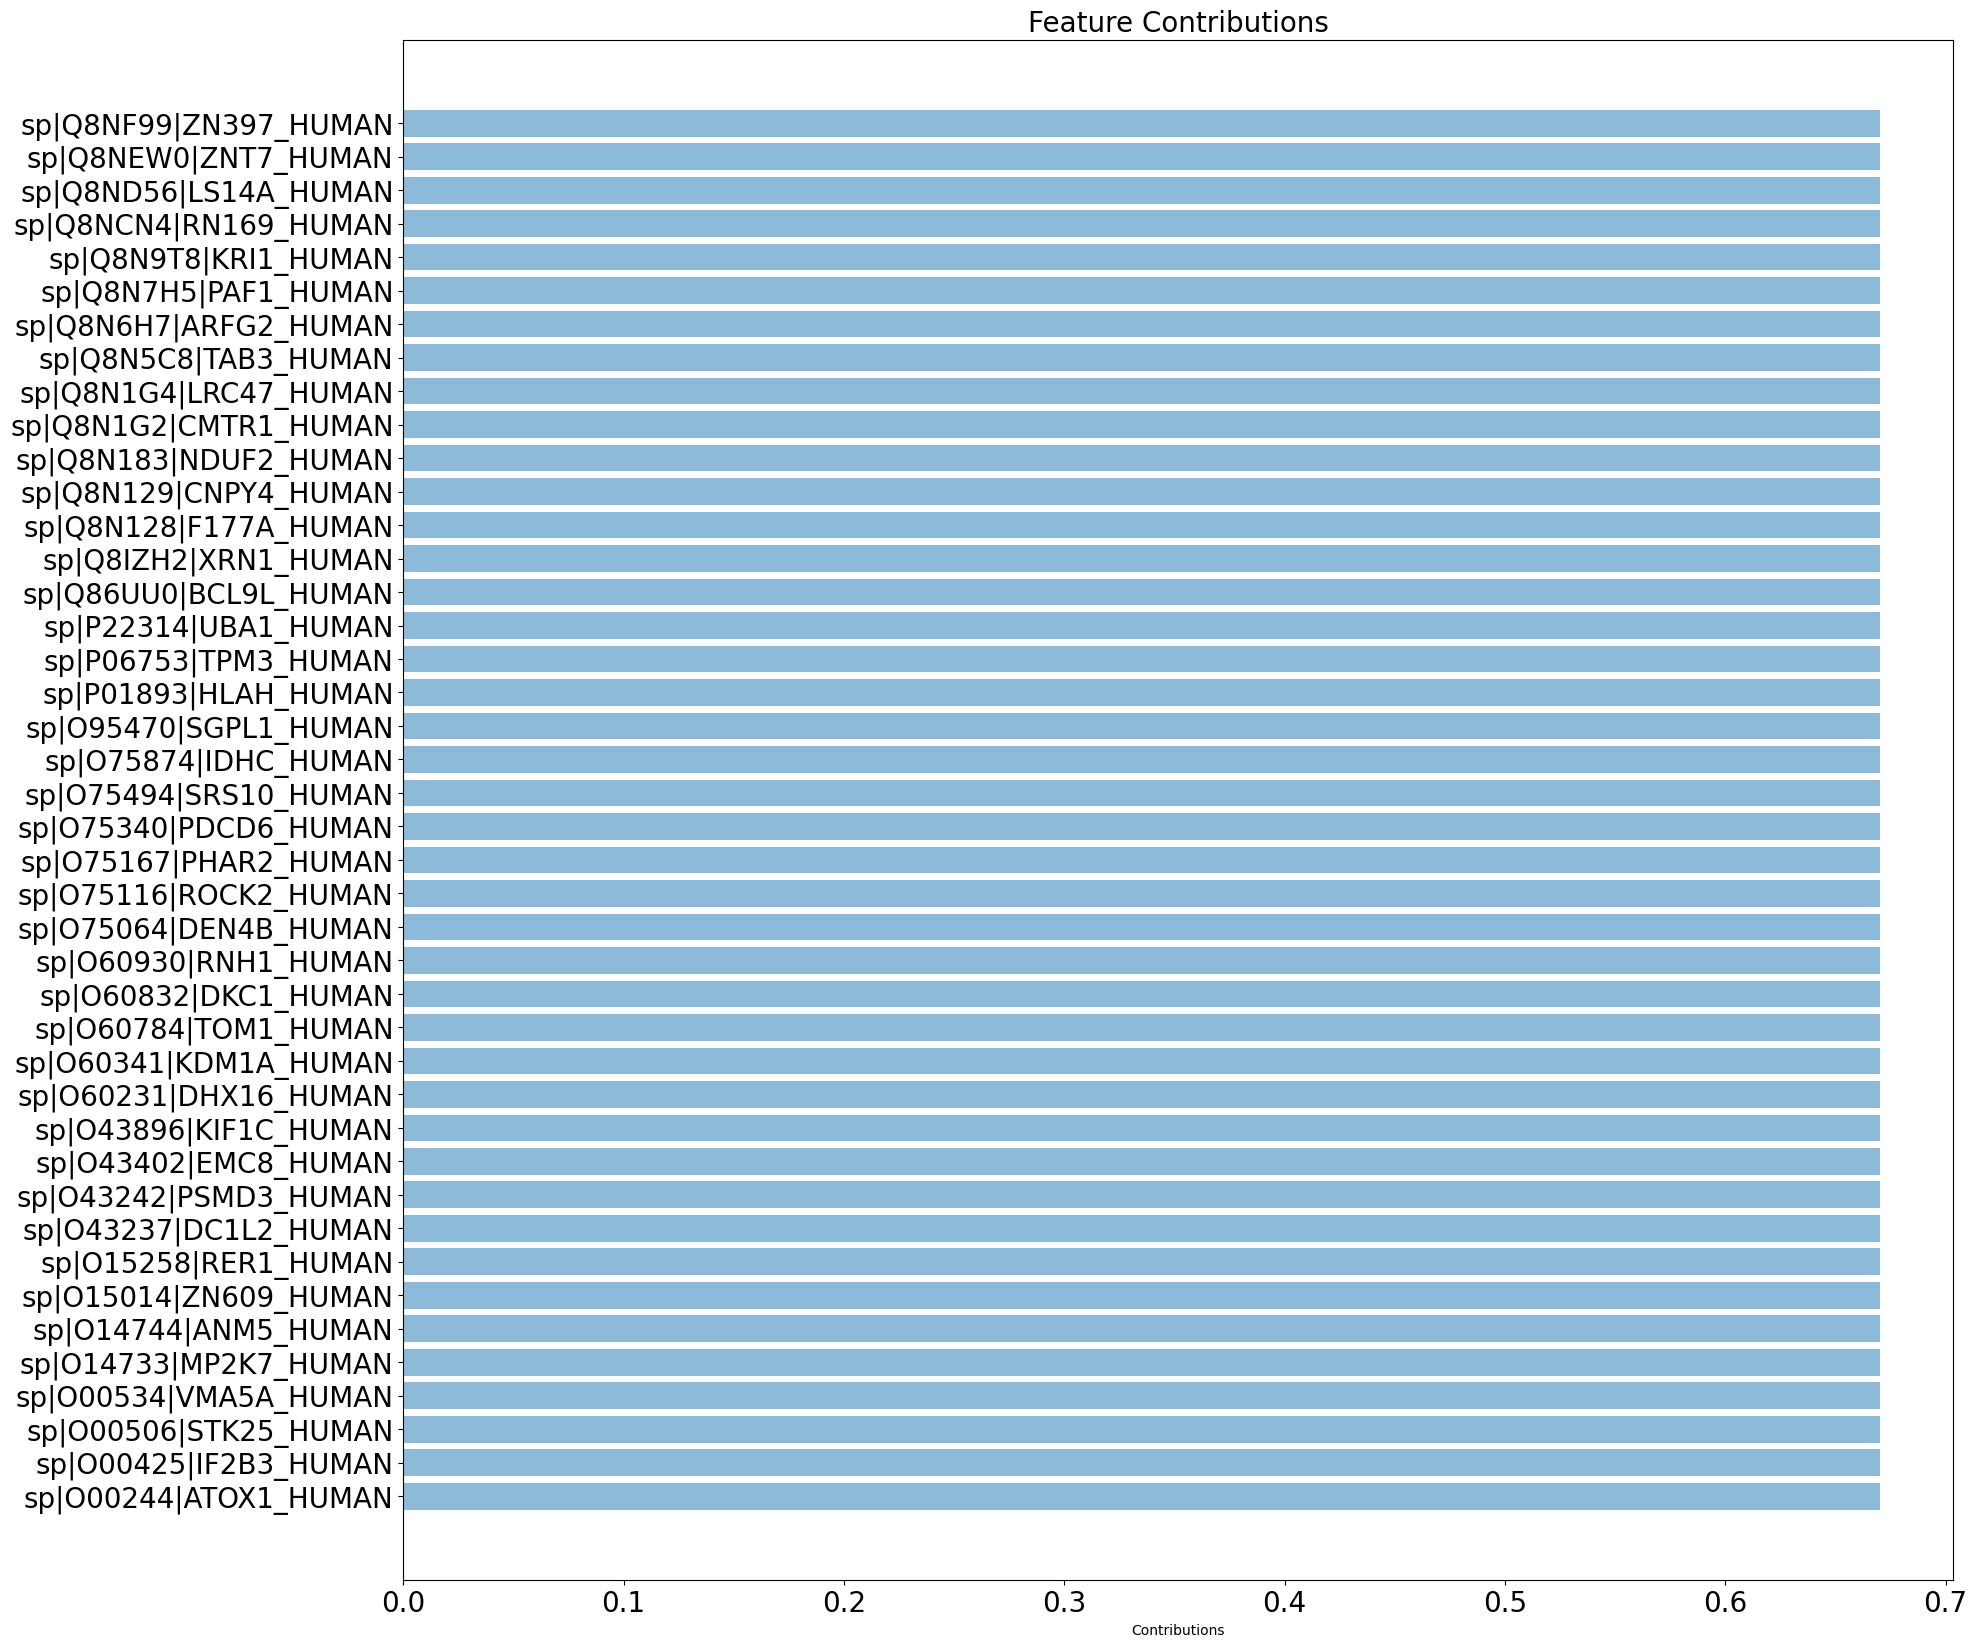

In [19]:
n_p=np.where(selector.support_ == False)[0]

feat=prot_abundance_norm.T.columns
to_drop=[]
for i in n_p:
    to_drop.append(feat[i])
x_imp=prot_abundance_norm.T.drop(to_drop,axis=1)

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = x_imp.columns
y_pos = np.arange(len(objects))
performance = selector.cv_results_['mean_test_score'][0]
fig, ax = plt.subplots(figsize=(20, 20))
plt.barh(y_pos, performance, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, objects,fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Contributions')
plt.title('Feature Contributions',fontsize=20)
plt.show()

do a prediction and output the score

##### Enrichment Analysis

### Observation and Conclusion:

#### 1. 
#### 2. Among the four , confounding effect can be further removed by PCA and clustering methods.
